In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as tud
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pointbiserialr, chi2_contingency
import matplotlib.pyplot as plt

In [12]:

# hyper parameters
LR          = 1e-3 
DROPOUT_P   = 0.3   
EPOCHS      = 100   

# -----------------------------------------------------------------------------#
# 1. loading the data
# -----------------------------------------------------------------------------#
FILE = "oasis_cross_sectional.xlsx"
df   = pd.read_excel(FILE)

df = df.dropna(subset=["CDR"])
df["label"] = (df["CDR"] > 0).astype(int)

numeric_cols      = ["Age", "Educ", "MMSE", "ASF", "eTIV", "nWBV"]
categorical_cols  = ["M/F", "Hand"]
df = df.dropna(subset=numeric_cols + categorical_cols).reset_index(drop=True)

numeric_xf     = Pipeline([("scaler", StandardScaler())])
categorical_xf = Pipeline([("ohe", OneHotEncoder(drop="first"))])
pre = ColumnTransformer(
    [("num", numeric_xf, numeric_cols),
     ("cat", categorical_xf, categorical_cols)]
)

print(len(df))

X = pre.fit_transform(df)
y = df["label"].values

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

train_ds = tud.TensorDataset(X_tr, y_tr)
val_ds   = tud.TensorDataset(X_val, y_val)
train_dl = tud.DataLoader(train_ds, batch_size=(len(train_ds)))
val_dl   = tud.DataLoader(val_ds,   batch_size=len(val_ds))


235


In [13]:
# -----------------------------------------------------------------------------#
# 2. model definition
# -----------------------------------------------------------------------------#
in_dim = X_tr.shape[1]

model = nn.Sequential(
    nn.Linear(in_dim, 64),
    nn.ReLU(),
    nn.Dropout(DROPOUT_P),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(DROPOUT_P),
    nn.Linear(32, 1)        # logits
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model.to(device)

pos_weight_val = (y_tr.shape[0] - y_tr.sum()) / y_tr.sum()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [14]:

# -----------------------------------------------------------------------------#
# 3. training
# -----------------------------------------------------------------------------#
train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
    train_loss_hist.append(loss.item())

    model.eval()
    with torch.no_grad():
        for xb_val, yb_val in val_dl:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            val_logits = model(xb_val)
            val_loss   = criterion(val_logits, yb_val).item()
            preds      = (val_logits.sigmoid() > 0.5).float()
            val_acc    = (preds == yb_val).float().mean().item()
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train_loss={loss.item():.4f} "
              f"| val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")


Epoch 01 | train_loss=0.7925 | val_loss=0.7807 | val_acc=0.7447
Epoch 05 | train_loss=0.7752 | val_loss=0.7550 | val_acc=0.8085
Epoch 10 | train_loss=0.7525 | val_loss=0.7254 | val_acc=0.8511
Epoch 15 | train_loss=0.7233 | val_loss=0.6968 | val_acc=0.8511
Epoch 20 | train_loss=0.7049 | val_loss=0.6660 | val_acc=0.8511
Epoch 25 | train_loss=0.6792 | val_loss=0.6330 | val_acc=0.8511
Epoch 30 | train_loss=0.6424 | val_loss=0.5989 | val_acc=0.8511
Epoch 35 | train_loss=0.6258 | val_loss=0.5640 | val_acc=0.8511
Epoch 40 | train_loss=0.5994 | val_loss=0.5307 | val_acc=0.8723
Epoch 45 | train_loss=0.5725 | val_loss=0.4999 | val_acc=0.8936
Epoch 50 | train_loss=0.5454 | val_loss=0.4728 | val_acc=0.8936
Epoch 55 | train_loss=0.5263 | val_loss=0.4506 | val_acc=0.8936
Epoch 60 | train_loss=0.5022 | val_loss=0.4336 | val_acc=0.8936
Epoch 65 | train_loss=0.4937 | val_loss=0.4214 | val_acc=0.8936
Epoch 70 | train_loss=0.4595 | val_loss=0.4127 | val_acc=0.8936
Epoch 75 | train_loss=0.4428 | val_loss=

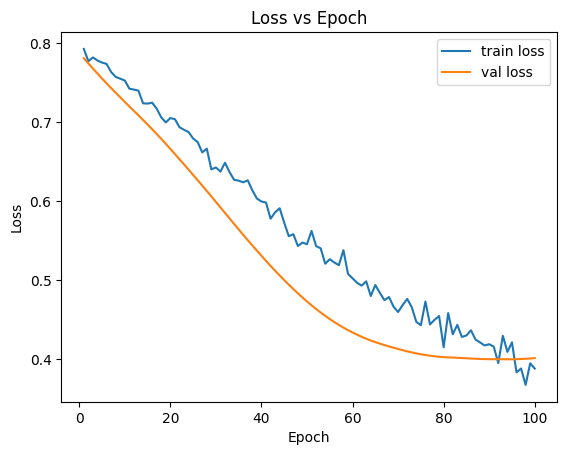

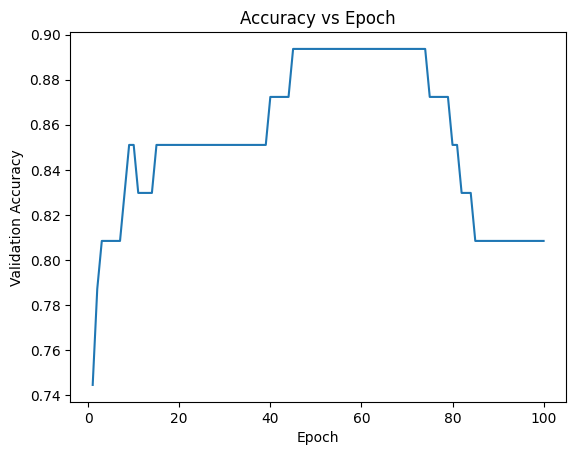

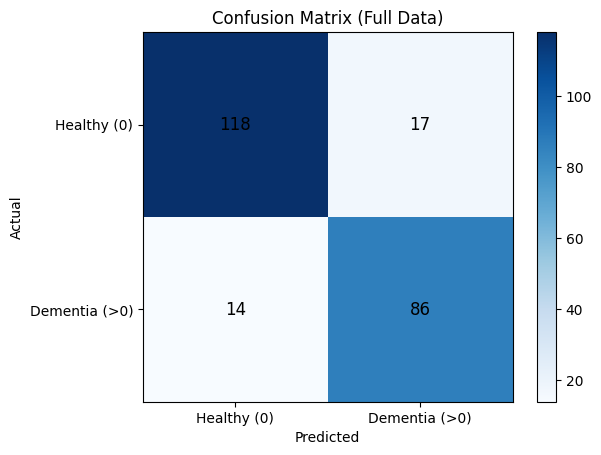

Classification report on validation set:
              precision    recall  f1-score   support

     Healthy       0.82      0.85      0.84        27
    Dementia       0.79      0.75      0.77        20

    accuracy                           0.81        47
   macro avg       0.81      0.80      0.80        47
weighted avg       0.81      0.81      0.81        47


Simple feature importance ranking
M/F_M              3.6955   (chi2)
MMSE               0.6402   (numeric‑corr (|r|))
nWBV               0.4885   (numeric‑corr (|r|))
Age                0.3150   (numeric‑corr (|r|))
Educ               0.2359   (numeric‑corr (|r|))
eTIV               0.1304   (numeric‑corr (|r|))
ASF                0.1274   (numeric‑corr (|r|))


In [15]:
# -----------------------------------------------------------------------------#
# 4a. loss and accuracy
# -----------------------------------------------------------------------------#
ep = np.arange(1, EPOCHS + 1)

plt.figure()
plt.plot(ep, train_loss_hist, label="train loss")
plt.plot(ep, val_loss_hist,   label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch"); plt.legend(); plt.show()

plt.figure()
plt.plot(ep, val_acc_hist)
plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy"); plt.title("Accuracy vs Epoch"); plt.show()

# -----------------------------------------------------------------------------#
# 4b. confusion matrix
# -----------------------------------------------------------------------------#
with torch.no_grad():
    yhat_val = (model(X_val.to(device)).sigmoid() > 0.5).cpu().numpy().astype(int).ravel()

cm = confusion_matrix(y, (model(torch.tensor(X, dtype=torch.float32).to(device))
                          .sigmoid() > 0.5).cpu().numpy().astype(int).ravel())
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Full Data)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
plt.xticks([0, 1], ["Healthy (0)", "Dementia (>0)"])
plt.yticks([0, 1], ["Healthy (0)", "Dementia (>0)"])
plt.colorbar(); plt.show()

print("Classification report on validation set:")
print(classification_report(y_val.numpy().ravel(), yhat_val, target_names=["Healthy", "Dementia"]))

# -----------------------------------------------------------------------------#
# 4‑c.  feature importance category attempt: numeric: point‑biserial correlation, categorical: chi‑square vs. label
# -----------------------------------------------------------------------------#
importance = []

# numeric correlations
for col in numeric_cols:
    r, p = pointbiserialr(df[col], df["label"])
    importance.append((col, abs(r), "numeric‑corr (|r|)"))

# one‑hot categorical stats
# get same encoding as we fed the model
cat_data = pre.named_transformers_["cat"]["ohe"].transform(df[categorical_cols])
cat_feature_names = pre.named_transformers_["cat"]["ohe"].get_feature_names_out(categorical_cols)
for idx, cname in enumerate(cat_feature_names):
    col = cat_data[:, idx].toarray().ravel()  # or .A1
    tbl = pd.crosstab(col, df["label"])
    chi2, p, *_ = chi2_contingency(tbl)
    importance.append((cname, chi2, "chi2"))

# sorted display

importance = sorted(importance, key=lambda x: x[1], reverse=True)
print("\nSimple feature importance ranking")
for name, score, kind in importance:
    print(f"{name:<15}  {score:>8.4f}   ({kind})")